# Customer Sentiment Analysis

<u>_Author: Ivy Araujo (21/06/2025)_</u>

<u>_Data: Mock customer feedback dataset generated to simulate reviews from a clothing store_</u>

This notebook leverages [Microsoft Fabric AI functions](https://learn.microsoft.com/en-us/fabric/data-science/ai-functions/overview?tabs=pyspark#getting-started-with-ai-functions), which uses the capabilities of large language models (LLMs), to analyse customer satisfaction sentiment for a clothing store using feedback collected from customers. The goal is to evaluate monthly trends in customer sentiment, helping the business understand how customers feel about its products and services over time and helping the business to implement continuous improvement.

In this case, the [ai.analyze_sentiment](https://learn.microsoft.com/en-us/fabric/data-science/ai-functions/analyze-sentiment) function is used to detect sentiment in text, identifying whether the emotional tone is positive, neutral, or negative. The result data can be written to a Lakehouse and visualised in a Power BI, providing insights for decision-makers.


##### Import Required Libraries and Default Configuration

In [1]:

from pyspark.sql.functions import when, col, expr # functions from PySpark for data manipulation
import pandas as pd # working with tabular data in Python
import matplotlib.pyplot as plt # data visualisation
from synapse.ml.spark.aifunc.DataFrameExtensions import AIFunctions # AI function extensions for Spark DataFrames from SynapseML
from synapse.ml.services.openai import OpenAIDefaults # default settings for OpenAI integration via SynapseML
defaults = OpenAIDefaults() # Initialise default configuration for OpenAI services
defaults.set_deployment_name("gpt-35-turbo-0125") # Set the deployment name for the OpenAI model to be used


StatementMeta(, 6a2abca9-8bb1-4b9a-b4f2-40944adf2b7a, 3, Finished, Available, Finished)

##### Read Input Data

In [2]:
df = spark.sql("SELECT * FROM Sandbox_DataScience_Test.custom_satisfaction_sentiment_analysis LIMIT 1000")
display(df)

StatementMeta(, 6a2abca9-8bb1-4b9a-b4f2-40944adf2b7a, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f6e7600a-dee7-4756-b80e-5e88a968bbee)

##### Sentiment Analysis with `ai.analyze_sentiment`

In this step,  `ai.analyze_sentiment` function is used to analyse the emotional tone of customer feedback. This function uses a LLM under the hood to interpret the sentiment expressed in natural language. The output is a new DataFrame with sentiment labels.

- **Input column**: `custom_satisfaction_comment` – the text data containing customer feedback.
- **Output column**: `sentiment` – the resulting sentiment classification for each comment.

In [3]:
sentiment = df.ai.analyze_sentiment(input_col="custom_satisfaction_comment", output_col="sentiment")
display(sentiment)

StatementMeta(, 6a2abca9-8bb1-4b9a-b4f2-40944adf2b7a, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2d03176a-5ca5-4ac3-8821-865b3aadb951)


##### Mapping Sentiment Labels to Custom Categories

To make the sentiment results more intuitive and business-friendly, original sentiment labels were mapped (`positive`, `neutral`, `mixed`, `negative`) to custom categories that reflect levels of customer satisfaction:

- **Positive** → *Very Satisfied*
- **Neutral** → *Satisfied*
- **Mixed** → *Neutral*
- **Negative** → *Not Satisfied*


In [4]:
# Map sentiment labels to custom categories
mapped_sentiment = sentiment.withColumn(
    "sentiment_category",
    when(col("sentiment") == "positive", "Very Satisfied")
    .when(col("sentiment") == "neutral", "Satisfied")
    .when(col("sentiment") == "mixed", "Neutral")
    .when(col("sentiment") == "negative", "Not Satisfied")
    .otherwise("N/A")  # Default case
)

# Display final result
display(mapped_sentiment.select(
    "date",
    "custom_satisfaction_comment",
    "sentiment",
    "sentiment_category"
))

StatementMeta(, 6a2abca9-8bb1-4b9a-b4f2-40944adf2b7a, 6, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9972ed12-be12-4133-8b91-d27a400139a7)

##### Write Output to Lakehouse

In [5]:
mapped_sentiment.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("Sandbox_DataScience_Test.processed_custom_satisfaction_sentiment_analysis")

display(spark.sql("SELECT * FROM Sandbox_DataScience_Test.processed_custom_satisfaction_sentiment_analysis LIMIT 5"))

StatementMeta(, 6a2abca9-8bb1-4b9a-b4f2-40944adf2b7a, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bbbc0de2-23af-40e5-b9b3-96e6c4c43ec9)

##### Visualise Monthly Sentiment Distribution

Convert the Spark DataFrame to a Pandas DataFrame to prepare the data for visualisation. The goal is to show how customer sentiment varies across different months.

StatementMeta(, 6a2abca9-8bb1-4b9a-b4f2-40944adf2b7a, 8, Finished, Available, Finished)

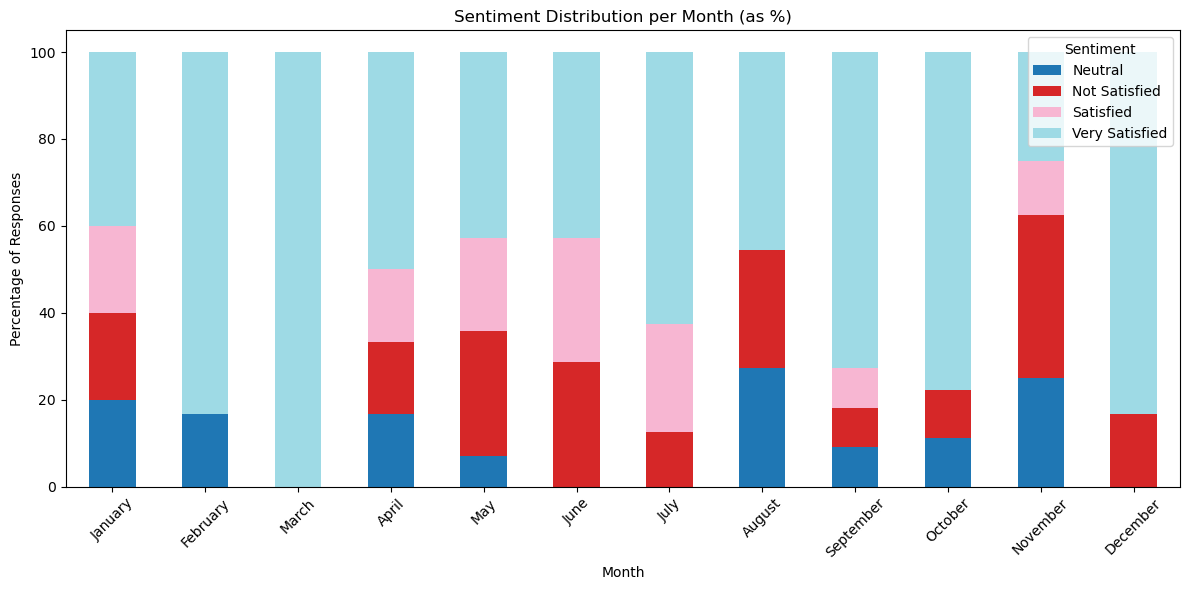

In [6]:
# Convert Spark DataFrame to Pandas
pdf = mapped_sentiment.select("date", "sentiment_category").toPandas()

# Convert 'date' to datetime and extract month name
pdf['date'] = pd.to_datetime(pdf['date'], format='%d/%m/%Y')
pdf['Month'] = pdf['date'].dt.strftime('%B')

# Group by Month and SentimentCategory and get counts
sentiment_counts = pdf.groupby(['Month', 'sentiment_category']).size().unstack(fill_value=0)

# Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
sentiment_counts = sentiment_counts.reindex(month_order).dropna(how='all')

# Convert to percentage (i.e., row-wise normalization)
sentiment_percent = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Plot normalised stacked bar chart (percentage per month)
sentiment_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

plt.title('Sentiment Distribution per Month (as %)')
plt.xlabel('Month')
plt.ylabel('Percentage of Responses')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()